In [1]:
import numpy as np
import pandas as pd
import pandas_profiling
from pandas import Series

from sklearn.feature_selection import f_classif, mutual_info_classif
from sklearn.preprocessing import LabelEncoder, OneHotEncoder, StandardScaler
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix, accuracy_score, f1_score, roc_auc_score, roc_curve

import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
pip install scipy --upgrade

Requirement already up-to-date: scipy in e:\anaconda\lib\site-packages (1.6.2)
Note: you may need to restart the kernel to use updated packages.


In [3]:
pip install pandas_profiling

Note: you may need to restart the kernel to use updated packages.


Познакомимся с данными:

In [4]:
data_train = pd.read_csv('train.csv')
data_test = pd.read_csv('test.csv')
data_sample = pd.read_csv('sample_submission.csv')

In [5]:
# Объединим наши датасеты в один для удобства:
data = pd.concat([data_train, data_test])

In [6]:
pandas_profiling.ProfileReport(data)

Summarize dataset:   0%|          | 0/33 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

Описание данных: client_id - идентификатор клиента

education - уровень образования

sex - пол заемщика

age - возраст заемщика

car - флаг наличия автомобиля

car_type - флаг автомобиля иномарки

decline_app_cnt - количество отказанных прошлых заявок

good_work - флаг наличия “хорошей” работы

bki_request_cnt - количество запросов в БКИ

home_address - категоризатор домашнего адреса

work_address - категоризатор рабочего адреса

income - доход заемщика

foreign_passport - наличие загранпаспорта

sna - связь заемщика с клиентами банка

first_time - давность наличия информации о заемщике

score_bki - скоринговый балл по данным из БКИ

region_rating - рейтинг региона

app_date - дата подачи заявки

default - флаг дефолта по кредиту

In [7]:
# Разделим все данные на три типа(бинарные, категориальные и численные)
bin_cols = [] 
cat_cols = [] 
num_cols = [] 

In [8]:
def visualizing_number(column):
    bins = 100
    if column.nunique() < 100:
        bins = column.nunique()
    column.hist(bins = bins)
    plt.show()
    sns.boxplot(x='default',y = column,data=data)
    plt.show()
    

def outliers(column):  # подсчет количества выбросов
    Q1 = column.quantile(0.25)
    Q3 = column.quantile(0.75)
    IQR = Q3 - Q1
    min_out = Q1 - 1.5 * IQR
    max_out = Q3 + 1.5 * IQR
    return (column < min_out).sum() + (column > max_out).sum(), min_out, max_out

Посмотрим на пропуски в данных:

In [9]:
data.isna().sum()

client_id               0
app_date                0
education             478
sex                     0
age                     0
car                     0
car_type                0
decline_app_cnt         0
good_work               0
score_bki               0
bki_request_cnt         0
region_rating           0
home_address            0
work_address            0
income                  0
sna                     0
first_time              0
foreign_passport        0
default             36349
dtype: int64

Пропуски есть только в одном стобце ['education'](на 'default' внимание не обращаем, эти значения нам надо предсказать. Разберемся с ними:

In [10]:
data['education'].value_counts()

SCH    57998
GRD    34768
UGR    14748
PGR     1865
ACD      291
Name: education, dtype: int64

По распределению значений в обучающей и тестовой выборке заполним пропущенные значения самым часто встречающимся 'SCH'



In [11]:
data['education'].fillna('SCH',inplace=True)

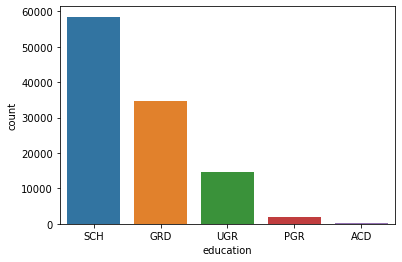

In [12]:
sns.countplot(x = data['education'], data = data)

In [13]:
# Определим  признак как категориальный:
cat_cols.append('education')

In [14]:
data.isna().sum()# Убедимся, что больше незаполненных значений в данных нет

client_id               0
app_date                0
education               0
sex                     0
age                     0
car                     0
car_type                0
decline_app_cnt         0
good_work               0
score_bki               0
bki_request_cnt         0
region_rating           0
home_address            0
work_address            0
income                  0
sna                     0
first_time              0
foreign_passport        0
default             36349
dtype: int64

В данных есть столбец с датой, на ее основе можно сразу сгенерить новый признак, например количество дней с даты подачи заявки и до сегодняшенго дня. Получим сразу чистовой признак ['num_days'],и добавим к данным

In [15]:
today = pd.to_datetime('2021-03-31')

In [16]:
data['app_date'] = pd.to_datetime(data['app_date'])

In [17]:
data['num_days'] = (today - data['app_date']).dt.days

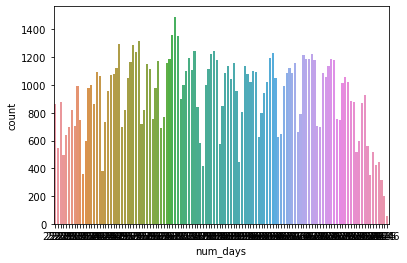

In [18]:
sns.countplot(x = data['num_days'], data = data)

Распределение близкое к нормальному, определим признак как числовой:

In [19]:
num_cols.append('num_days')

Признак sex - пол заемщика
Из ProfileReport видим, что тут только 2 значения, пропусков нет, посмотрю распределение относительно целевого признака

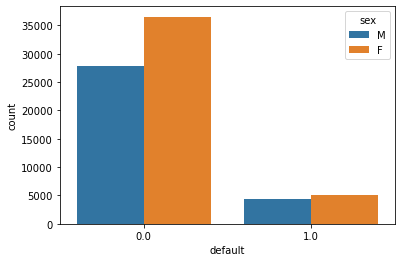

In [20]:
sns.countplot(x= data['default'],hue = data['sex'], data = data)

Наиболее ответственные заемщицы-женщины. Больше ответственных заемщиков чем дефолтных.

Определим признак как бинарный:

In [21]:
bin_cols.append('sex')

Рассмотрим признак возраст:

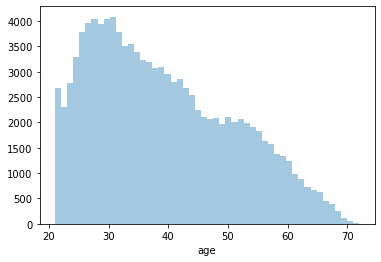

In [22]:
sns.distplot(data['age'], kde=False)


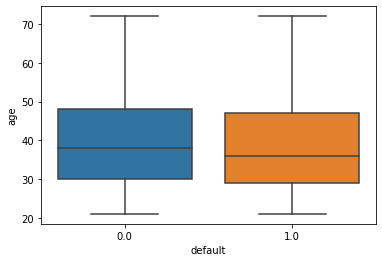

In [23]:
sns.boxplot(x='default',y = 'age',data=data)

Выбросов нет, распределение близко к нормальному, оставим как есть

In [24]:
num_cols.append('age')

Признаки ниличия авто и наличия иностранного авто:

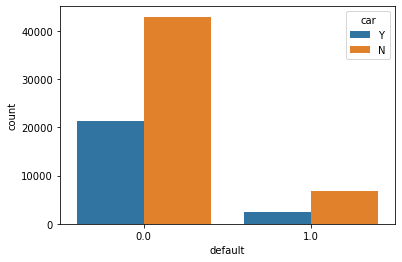

In [25]:
sns.countplot(x = data['default'], hue= data['car'], data = data)

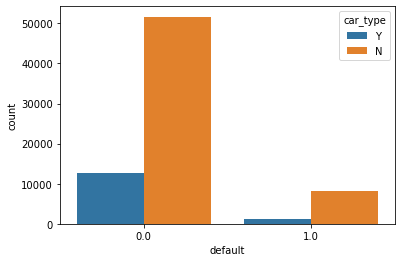

In [26]:
sns.countplot(x = data['default'], hue= data['car_type'], data = data)

Дефолтов больше у кого нет машины, у кого есть иномарка дефолты редки. Добавим к бинарным признакам:

In [27]:
bin_cols.append('car')
bin_cols.append('car_type')

Признак decline_app_cnt - количество отказанных прошлых заявок
Из ProfileReport видим, признак числовой. Сильное смещение. Посмотрю что это за значения и есть ли выбросы

18677


0     91471
1     12500
2      3622
3      1365
4       606
5       255
6       156
7        58
8        37
9        29
10       16
11       10
12        5
13        4
14        3
16        3
30        1
15        1
19        1
20        1
21        1
22        1
24        1
33        1
Name: decline_app_cnt, dtype: int64

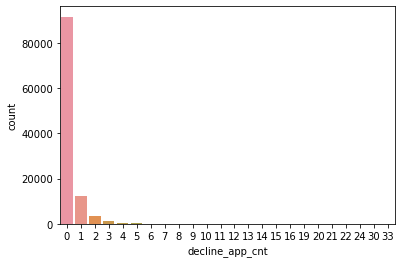

In [28]:
print(outliers(data.decline_app_cnt)[0])
sns.countplot(x = 'decline_app_cnt', data = data)
data.decline_app_cnt.value_counts()

Много выбросов, большинство значений это 0. Сделаем признак категориальным:

In [29]:
data.decline_app_cnt = data.decline_app_cnt.apply(lambda x: x if x < 3 else 3)
data.decline_app_cnt.value_counts()
cat_cols.append('decline_app_cnt')

Признак  good_work: бинарный.Из profile  видно, что выбросов нет, распределение относительно целевой переменной:

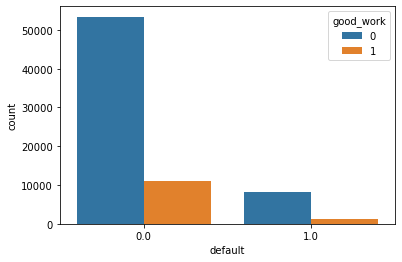

In [30]:
sns.countplot(x = data['default'], hue= data['good_work'], data = data)

Если работа хорошая, то клиент в целом не дефолтный.

In [31]:
bin_cols.append('good_work')

Скоринговый балл БКИ score_bki: 
Из ProfileReport видно - это числовой признак. Распределение нормальное. Пропусков нет, много уникальных значений. Проверю на выбросы

In [32]:
outs, min_out, max_out = outliers(data['score_bki'])
print('Всего выбросов: {} \nДоля выбросов: {}'.format(outs, outs / data.shape[0] *100))

Всего выбросов: 518 
Доля выбросов: 0.47027635544903224


Исключим выбросы, определим признак как числовой.

In [33]:
data = data[((data.default.isna() == False) & (
    data['score_bki'].between(min_out, max_out))) | data.default.isna() == True]
num_cols.append('score_bki')

Признак bki_request_cnt - количество запросов в БКИ
Из Profile  видно, что признак числовой с сильным смещением. Попробуем нормализовать его с попощью логарифмирования:

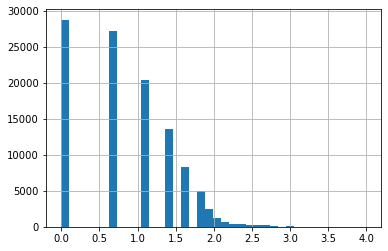

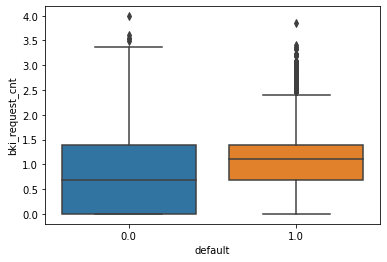

Всего выбросов: 12 
Доля выбросов: 0.01092816552528049


In [34]:
visualizing_number(np.log(data['bki_request_cnt'] + 1))
outs, min_out, max_out = outliers(np.log(data['bki_request_cnt'] + 1))
print('Всего выбросов: {} \nДоля выбросов: {}'.format(outs, outs / data.shape[0] *100))

Выбросов немного, логарифмирование помогло, удалим оставшиеся выбросы и добавим признак к числовым.

In [35]:
data['bki_request_cnt'] = np.log(data['bki_request_cnt'] + 1)
data = data[((data.default.isna() == False) & (data['bki_request_cnt'].between(min_out, max_out))) | data.default.isna() == True]
num_cols.append('bki_request_cnt')

Признак region_rating.

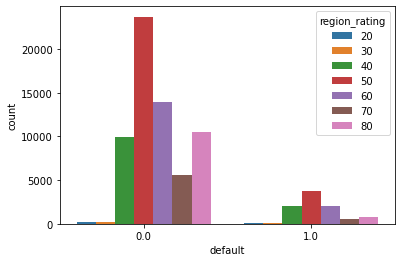

In [36]:
sns.countplot(x = data['default'], hue= data['region_rating'], data = data)

In [37]:
outs, min_out, max_out = outliers(np.log(data['region_rating'] + 1))
print('Всего выбросов: {} \nДоля выбросов: {}'.format(outs, outs / data.shape[0] *100))

Всего выбросов: 17842 
Доля выбросов: 16.24924864756562


Выбросов достаточно много, оставим их. Добавим признак к категориальным

In [38]:
cat_cols.append('region_rating')

Признаки:
home_address - категоризатор домашнего адреса
work_address - категоризатор рабочего адреса

Добавим к категориальным:

In [39]:
cat_cols.append('home_address')
cat_cols.append('work_address')

Признак income - доход заемщика
Из ProfileReport видим, что это числовой признак. Распределение смещено влево .

Всего выбросов: 6968 
Доля выбросов: 6.3459681973005955


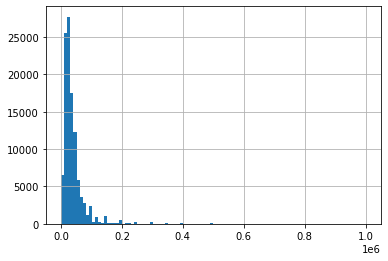

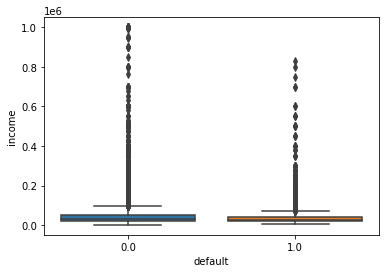

In [40]:
outs, min_out, max_out = outliers(data['income'])
print('Всего выбросов: {} \nДоля выбросов: {}'.format(outs, outs / data.shape[0] *100))
visualizing_number(data.income)

Выбросов много. Применим логарифмирование, чтобы улучшить распределение признака:

outs, min_out, max_out = outliers(np.log(data['income'] + 1))
print('Всего выбросов: {} \nДоля выбросов: {}'.format(outs, outs / data.shape[0] *100))
visualizing_number(np.log(data['income'] + 1))

Количество выбросов сократилось. Распределение стало более нормальным. Применим логарифмирование к признаку:
    Добавим признак к числовым:

In [41]:
data['income'] = np.log(data['income'] + 1)
num_cols.append('income')

Признаки:
sna - связь заемщика с клиентами банка
first_time - давность наличия информации о заемщике
Из ProfileReport видим, что это категориальные признак. Пропусков нет, возможно 4 значения. Добавлю в категориальные признаки

In [42]:
cat_cols.append('sna')
cat_cols.append('first_time')

Признак foreign_passport - наличие загранпаспорта
По ProfileReport видно - признак бинарный. Добавлю в бинарные признаки. Пропусков нет

In [43]:
bin_cols.append('foreign_passport')

Обработка и анализ числовых признаков

Построим график корреляции для числовых признаков: По графику видно, что у нас нет сильно коррелирующих признаков, что может плохо повлиять на линейную модель обучения Из графика корреляции можно заметить, что доход сильно зависит от рейтинга региона проживания, ну или наоборот, если человек хорошо зарабатывает, то он живет в приличном месте.

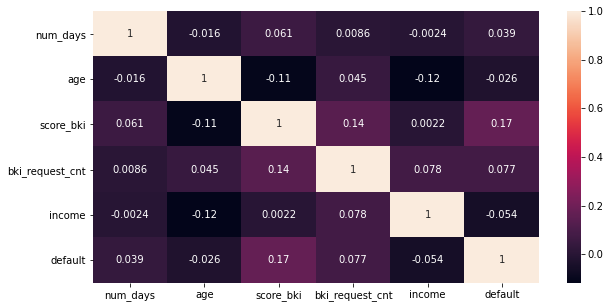

In [44]:
plt.figure(figsize=(10,5))
sns.heatmap(data[num_cols+['default']].corr(), annot=True)

Посмотрим какой признак важнее для нашего таргета:

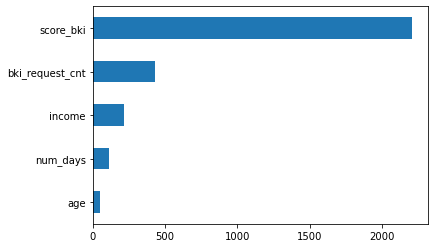

In [45]:
imp_num = Series(f_classif(data[data.default.isna() == False][num_cols], data[data.default.isna() == False]['default'])[0], index = num_cols)
imp_num.sort_values(inplace = True)
imp_num.plot(kind = 'barh')

Признак score_bki является самым важным, а возраст наоборот-самый незначительный.

Обработка и анализ бинарных признаков:

Преобразую отобранные признаки в бинарные

In [46]:
label_encoder = LabelEncoder()
for i in bin_cols:
    data[i] = label_encoder.fit_transform(data[i])

In [47]:
data[bin_cols].head()

sex  car  car_type  good_work  foreign_passport
0    1    1         1          0                 0
1    0    0         0          0                 0
2    1    1         0          0                 1
3    0    0         0          0                 0
4    1    0         0          1                 1

In [48]:
for i in bin_cols:
    display(data[i].value_counts())


0    61637
1    48165
Name: sex, dtype: int64

0    74050
1    35752
Name: car, dtype: int64

0    88857
1    20945
Name: car_type, dtype: int64

0    91629
1    18173
Name: good_work, dtype: int64

0    93439
1    16363
Name: foreign_passport, dtype: int64

Посмотрим значимость бинарных признаков:

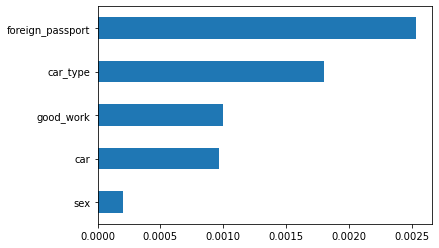

In [49]:
imp_cat = Series(mutual_info_classif(data[data.default.isna() == False][bin_cols], data[data.default.isna() == False]['default'],
                                     discrete_features =True), index = bin_cols)
imp_cat.sort_values(inplace = True)
imp_cat.plot(kind = 'barh')

Наличие загранпаспорта - самый значимый признак:

Обработка и анализ категориальных признаков:

Преобразую все значения в числа и посмотрю на значимость признаков

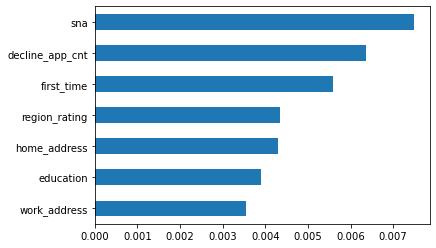

In [50]:
for i in cat_cols:
    label_encoder.fit(data[i])
    data[i] = label_encoder.transform(data[i])
    
imp_cat = Series(mutual_info_classif(data[data.default.isna() == False][cat_cols], data[data.default.isna() == False]['default'],
                                     discrete_features =True), index = cat_cols)
imp_cat.sort_values(inplace = True)
imp_cat.plot(kind = 'barh')

Категориальные признаки все достаточно значимы для модели:

In [51]:
data[cat_cols].head()

education  decline_app_cnt  region_rating  home_address  work_address  sna  \
0          3                0              3             0             1    3   
1          3                0              3             1             2    3   
2          3                2              6             0             1    0   
3          3                0              3             1             2    0   
4          1                0              4             1             2    0   

   first_time  
0           0  
1           0  
2           3  
3           2  
4           3

Преобразуем категориальные признаки в dummy переменные:

In [52]:
data = pd.get_dummies(data, columns = cat_cols)

In [53]:
data.head(5)

client_id   app_date  sex  age  car  car_type  good_work  score_bki  \
0      25905 2014-02-01    1   62    1         1          0  -2.008753   
1      63161 2014-03-12    0   59    0         0          0  -1.532276   
2      25887 2014-02-01    1   25    1         0          0  -1.408142   
3      16222 2014-01-23    0   53    0         0          0  -2.057471   
4     101655 2014-04-18    1   48    0         0          1  -1.244723   

   bki_request_cnt     income  ...  work_address_1  work_address_2  sna_0  \
0         0.693147   9.798183  ...               1               0      0   
1         1.386294   9.852247  ...               0               1      0   
2         0.693147  10.308986  ...               1               0      1   
3         1.098612   9.210440  ...               0               1      1   
4         0.693147  10.308986  ...               0               1      1   

   sna_1  sna_2  sna_3  first_time_0  first_time_1  first_time_2  first_time_3  
0      0      0      1             1             0             0             0  
1      0      0      1             1             0             0             0  
2      0      0      0             0             0             0             1  
3      0      0      0             0             0             1             0  
4      0      0      0             0             0             0             1  

[5 rows x 43 columns]

Обучение


In [54]:
def count_metrics(y_test, y_pred, y_probs):    
    metrics = {}
    metrics['accuracy'] = accuracy_score(y_test, y_pred)
    metrics['f1'] = f1_score(y_test, y_pred)
    metrics['roc_auc'] = roc_auc_score(y_test, y_probs)  
    metrics['confusion'] = confusion_matrix(y_test, y_pred)
    return metrics 

def show_roc_auc(y_test, y_probs):
    fpr, tpr, threshold = roc_curve(y_test, y_probs)
    roc_auc = roc_auc_score(y_test, y_probs)
    plt.figure()
    plt.plot([0, 1], label='Baseline', linestyle='--')
    plt.plot(fpr, tpr, label = 'Regression')
    plt.title('Logistic Regression ROC AUC = %0.3f' % roc_auc)
    plt.ylabel('True Positive Rate')
    plt.xlabel('False Positive Rate')
    plt.legend(loc = 'lower right')
    plt.show()

Сначала выделю тестовую и тренировочную части.

In [55]:
data_train = data[data.default.isna() == False]
data_test = data[data.default.isna() == True]

Наивная модель


In [56]:
X = data_train.drop(['client_id','app_date','default'], axis=1).values
Y = data_train['default'].values


In [57]:
# Делю данные на еще один тест и трейн, для валидации,  
# чтобы проверить, как хорошо модель работает, до отправки submissiona на kaggle.
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.20, random_state=42)

In [58]:
#само обучение
model_naive = LogisticRegression(solver = 'liblinear')
model_naive.fit(X_train, y_train)
y_pred = model_naive.predict(X_test)
y_probs = model_naive.predict_proba(X_test)[:,1]


In [59]:
#посмотрю метрики
metrics_naive = count_metrics(y_test, y_pred, y_probs)
data_metrics = pd.DataFrame.from_dict(metrics_naive, orient='index',columns = ['naive'])

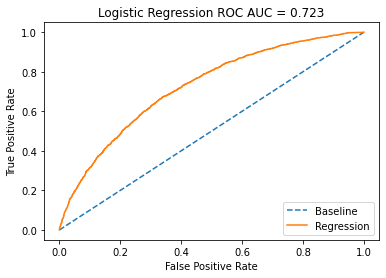

naive
accuracy                    0.873664
f1                          0.035343
roc_auc                     0.723437
confusion  [[12801, 37], [1819, 34]]

In [60]:
show_roc_auc(y_test, y_probs)
display(data_metrics)

Сразу бросается в глаза ошибка второго рода, дефолтных клиентов угадываю хуже. Проверю распределение целевой переменной

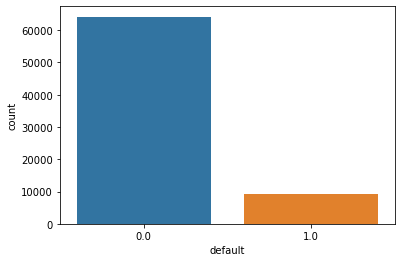

In [61]:
sns.countplot(x = data_train['default'], data = data_train)

Распределение целевой переменной несбалансировано. Попробую выровнять количество в дефолтной и недефолтной категориях

Модель с выравниванием классов:

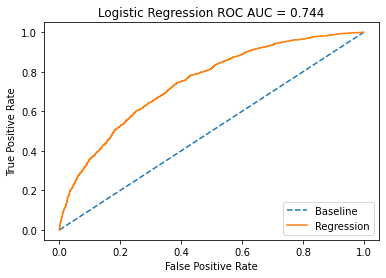

naive                    balanced
accuracy                    0.873664                    0.673502
f1                          0.035343                     0.66976
roc_auc                     0.723437                    0.743786
confusion  [[12801, 37], [1819, 34]]  [[1269, 607], [603, 1227]]

In [62]:
#выравниваю категории
classes = data_train.default.value_counts(ascending=True)
minor = data_train[data_train.default == classes.index[0]]
other = data_train[data_train.default.isin(classes.index[1:])][:classes.iloc[0]]
data_train_balanced = pd.concat([other, minor])

X = data_train_balanced.drop(['client_id','app_date','default'], axis=1).values
Y = data_train_balanced['default'].values

# Делю данные на еще один тест и трейн
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.20, random_state=42)

#само обучение
model_balanced = LogisticRegression(solver = 'liblinear')
model_balanced.fit(X_train, y_train)
y_pred = model_balanced.predict(X_test)
y_probs = model_balanced.predict_proba(X_test)[:,1]

#посмотрю метрики
metrics_balanced = count_metrics(y_test, y_pred, y_probs)
data_metrics['balanced'] = pd.Series(metrics_balanced)

show_roc_auc(y_test, y_probs)
display(data_metrics)


По confusion matrix видим, что теперь модель угадывает и дефотных и недефолтных равномерно. Попробую улучшить метрики используя нормализацию числовых признаков, т.к. там был разный масштаб

Модель с нормализацией и underfitting

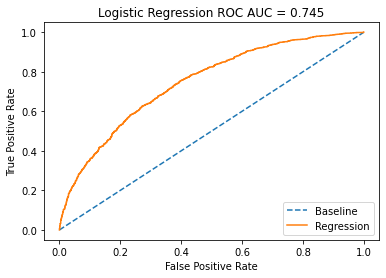

naive                    balanced  \
accuracy                    0.873664                    0.673502   
f1                          0.035343                     0.66976   
roc_auc                     0.723437                    0.743786   
confusion  [[12801, 37], [1819, 34]]  [[1269, 607], [603, 1227]]   

                         std_balanced  
accuracy                     0.675931  
f1                           0.673197  
roc_auc                      0.744899  
confusion  [[1268, 608], [593, 1237]]

In [63]:
#нормализация
num_cols_std = StandardScaler().fit_transform(data_train_balanced[num_cols].values)

X = np.hstack([data_train_balanced.drop(num_cols + ['client_id','app_date','default'], axis=1), num_cols_std])
Y = data_train_balanced['default'].values

# Делю данные на еще один тест и трейн
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.20, random_state=42)

#само обучение
model_std_balanced = LogisticRegression(solver = 'liblinear')
model_std_balanced.fit(X_train, y_train)
y_pred = model_std_balanced.predict(X_test)
y_probs = model_std_balanced.predict_proba(X_test)[:,1]

#посмотрю метрики
metrics_std_balanced = count_metrics(y_test, y_pred, y_probs)
data_metrics['std_balanced'] = pd.Series(metrics_std_balanced)

show_roc_auc(y_test, y_probs)
display(data_metrics)

Модель с нормализацией и underfitting. Подбор гиперпараметров

In [64]:
# Задаю ограничения для параметра регуляризации
C = np.logspace(0, 4, 10)

penalty = ['l1','l2']
hyperparameters = dict(C=C, penalty=penalty)

model = LogisticRegression(solver = 'liblinear')
model.fit(X_train, y_train)

clf = GridSearchCV(model, hyperparameters, cv=5, verbose=0)

best_model = clf.fit(X_train, y_train)

print('Лучший penalty:', best_model.best_estimator_.get_params()['penalty'])
print('Лучшее C:', best_model.best_estimator_.get_params()['C'])

Лучший penalty: l2
Лучшее C: 2.7825594022071245


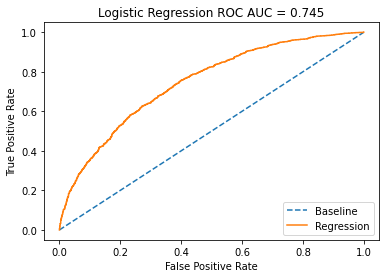

naive                    balanced  \
accuracy                    0.873664                    0.673502   
f1                          0.035343                     0.66976   
roc_auc                     0.723437                    0.743786   
confusion  [[12801, 37], [1819, 34]]  [[1269, 607], [603, 1227]]   

                         std_balanced                      finish  
accuracy                     0.675931                    0.675931  
f1                           0.673197                    0.673197  
roc_auc                      0.744899                    0.744861  
confusion  [[1268, 608], [593, 1237]]  [[1268, 608], [593, 1237]]

In [65]:
#обучаю модель с подобранными параметрами
model_finish = LogisticRegression(penalty='l2', C=2.7825594022071245, max_iter=1000, solver = 'liblinear')
model_finish.fit(X_train, y_train)

y_pred = model_finish.predict(X_test)
y_probs = model_finish.predict_proba(X_test)[:,1]

#посмотрю метрики
metrics_finish = count_metrics(y_test, y_pred, y_probs)
data_metrics['finish'] = pd.Series(metrics_finish)

show_roc_auc(y_test, y_probs)
display(data_metrics)

Метрики улучшаются на сотые доли. Единственный большй прорыв получился после балансировки категорий. Для улучшения метрик можно было бы еще попробовать:

Поиграть с гиперпараметрами
Вернуться к анализу признаков и попробовать их изменить. Например, созданные числовые признаки с датами (сезон, день недели...) перевести в категориальные и сделать дамми переменные и т.д.
Изменить модель обучения и попробовать другие виды
На текущий момент оставлю в таком виде и возьму последнюю модель лучшими показателями

Submission

In [66]:
# проверю что требуется
data_sample.sample(3)

client_id   default
3199        1074  0.657282
17126      12675  0.388247
10269      74096  0.436396

In [67]:
#расчет на тестовых данных
num_cols_std = StandardScaler().fit_transform(data_test[num_cols].values)
X_test = np.hstack([data_test.drop(num_cols + ['client_id','app_date','default'], axis=1), num_cols_std])
y_probs = model_finish.predict_proba(X_test)[:,1]
data_test['default'] = y_probs

<ipython-input-67-1c1bc9956067>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_test['default'] = y_probs


In [68]:
#проверка что получилось
submission = data_test[['client_id','default']]
submission.to_csv('submission.csv', index=False)
submission.sample(3)

client_id   default
28755       7761  0.761228
28320     101780  0.845774
34105       6719  0.785201